# How do scientific papers get cited?
Our purpose in this notebook is to analyze the structure of graphs generated by citation patterns from scientific papers. Each scientific paper cites many other papers, say 20-40, and sometimes (e.g., review papers) hundreds of other papers. So, it might be interesting to ask: Are the cited papers chosen randomly (from within the domain of the paper) or is there some "hidden pattern"?

Given that we will be looking at "paper `i` cites paper `j`" relationships, it makes sense to represent the citation data as a directed graph (a citation graph) in which the nodes correspond to papers, and there is an edge from node `i` to node `j` if the paper corresponding to node `i` cites the paper corresponding to node `j`. Since we're interested in understanding how papers get cited, we will analyze the in-degree distribution of a specific graph, and contrast it to those of graphs generated by two different random processes.

## Loading the data
First, we will load a provided citation graph for 27,770 high energy physics theory papers. This graph has 352,768 edges. The largest number of citatitions found in these papers is 562, while some papers do not cite other papers at all.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import re
from urllib.request import urlopen, Request

FILE_URL = "http://storage.googleapis.com/codeskulptor-alg/alg_phys-cite.txt"

# helper functions
def create_digraph(url):
    """
    Reading a graph in txt format from the web.
    Returns a dictionary whose keys are nodes of the graph,
    and values are the nodes to which there is an edge
    from the key.
    """
    request = Request(url)
    response = urlopen(request)
    text_graph = response.readlines()
    response.close()
    digraph = {}
    for line in text_graph:
        str_line = re.findall(b"\d+", line)
        key = int(str_line[0])
        values = [int(value) for value in str_line[1:]]
        digraph[key] = set(values)

    return digraph

citation_graph = create_digraph(FILE_URL)

print("The number of papers is", len(citation_graph))
print("The number of edges is", sum(len(value) for value in citation_graph.values()))
print("max out-degree", max(len(value) for value in citation_graph.values()))
print("min out-degree", min(len(value) for value in citation_graph.values()))

The number of papers is 27770
The number of edges is 352768
max out-degree 562
min out-degree 0


## Computing the in-degree distribution
Now, we will compute the in-degree distribution for this citation graph and then normalize the distribution (make the values in the dictionary sum to one).

In [2]:
def compute_in_degrees(digraph):
    """
    Computes the in-degrees for the nodes in the
    directed graph.
    Returns a dictionary with the same set of keys
    (nodes) as the digraph whose corresponding
    values are the number of edges whose head
    matches a particular node.
    """
    degree_dict = {}
    citations = digraph.values()

    # checking for papers with non-zero in-degree
    for citation_set in citations:
        for paper in citation_set:
            if paper in degree_dict:
                degree_dict[paper] += 1
            else:
                degree_dict[paper] = 1

    # adding papers with zero in-degree
    for paper in digraph:
        if paper not in degree_dict:
            degree_dict[paper] = 0

    return degree_dict

def in_degree_distribution(digraph):
    """
    Computes the normalized distribution of the
    in-degrees of the graph.
    Returns a dictionary whose keys correspond to
    in-degrees of nodes in the graph. Values are
    the fraction of nodes with that in-degree.
    """
    degree_dict = compute_in_degrees(digraph)
    dict_lenth = len(degree_dict)

    # computing an unnormalized distribution
    dist_unnormalized = {}
    in_degrees = degree_dict.values()
    for in_degree in in_degrees:
        if in_degree in dist_unnormalized:
            dist_unnormalized[in_degree] += 1
        else:
            dist_unnormalized[in_degree] = 1

    # computing a normalized distribution
    dist_normalized = {}
    for in_degree, frequency in dist_unnormalized.items():
        dist_normalized[in_degree] = frequency / dict_lenth

    return dist_normalized

citation_graph = create_digraph(FILE_URL)
in_degree_citation = in_degree_distribution(citation_graph)

Now, we will construct a log/log plot of the points in this normalized distribution since the in-degrees display several orders of magnitude.

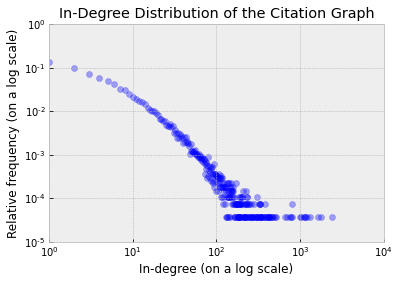

In [3]:
def plot_in_degree(graph, x_limits, y_limits, title, color):
    """
    Plots the directed `graph` which is represented as a dictionary.  
    The keys of the dictionary should correspond to the in-degrees 
    of nodes in the graph. Values are the fraction of nodes 
    having that in-degree.
    """
    plt.style.use("bmh")
    fig, ax = plt.subplots()
    ax.scatter(graph.keys(), graph.values(),
               alpha = 0.35, color = color)
    ax.set_xscale('log')
    ax.set_xlim(x_limits[0], x_limits[1])
    ax.set_yscale('log')
    ax.set_ylim(y_limits[0], y_limits[1])
    ax.minorticks_off()
    ax.set_xlabel("In-degree (on a log scale)")
    ax.set_ylabel("Relative frequency (on a log scale)")
    ax.set_title("In-Degree Distribution of the " + title)
    plt.show()

plot_in_degree(in_degree_citation, (1, 10**4), (10**(-5), 1),
               "Citation Graph", "blue")

## First random graph
First, let's consider a simple algorithm that iteratively creates a graph in which there is a directed edge `(i, j)` from `i` to `j` with some fixed probability `p`. We will call this graph a binomial graph because each individual node can be connected to any other node with an independent and fixed probability. Since we have 352,768 edges and 27,770 nodes, each node has on average 352,768 / 27,770 = 13 out-degree. So, we need such `p` that makes the expected out-degree of each individual node 13. As a final step, we will transform this graph into one showing the normalized in-degree distribution.

In [4]:
def make_binomial(num_nodes, prob):
    """
    Creates a directed graph whereby there is an edge from each 
    node to all other nodes with probability `prob`.
    
    Returns a dictionary whose keys are nodes and values are edges 
    whose tails are at key nodes.
    """
    digraph = {node: set() for node in citation_graph}
    for key_node in citation_graph:
        for value_node in citation_graph:
            if (key_node != value_node):
                a = np.random.rand()
                if a < prob:
                    digraph[key_node].add(value_node)
    
    return digraph

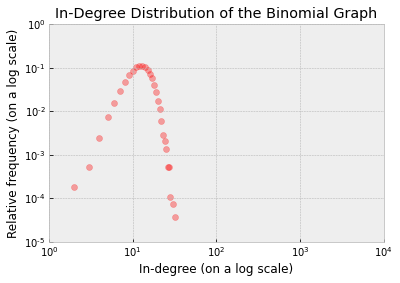

In [5]:
NUM_NODES = 27770
NUM_NEIGHBORS = 13
binom1 = make_binomial(NUM_NODES, NUM_NEIGHBORS / (NUM_NODES-1))
in_degree_binom1 = in_degree_distribution(binom1)
plot_in_degree(in_degree_binom1, (1, 10**4), (10**(-5), 1),
               "Binomial Graph", "red")

The above plot is very different from the in-degree distribution plot of the citation graph; however, the code still produced an intuitive and expected output. Each node has `n` = 27,769 other nodes to receive an edge from (with probability `p`). Therefore, the expected in-degree of a node is the same as its expected out-degree$-$13. Since both `np` and `np(1-p)` are greater than 10, this binomial distribution can be approximated by a Normal distribution$- \mathcal N \left(np, \; np(1-p) \right)$. This explains why the graph has a familiar bell-shaped curve. 

Finally, the brute-force algorithm in the previous cell was painfully slow. Since we are interested in the in-degree distribution plot and not in the underlying graph, we can also use the following faster method to generate the plot.

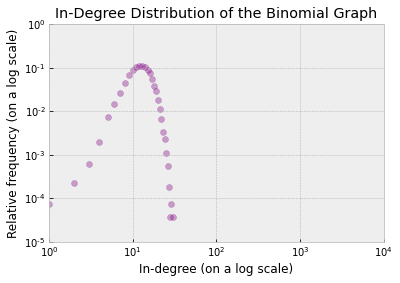

In [6]:
binom_sample = np.random.binomial(
    n = NUM_NODES-1, p = NUM_NEIGHBORS / (NUM_NODES-1), size=NUM_NODES)
unique, counts = np.unique(binom_sample, return_counts=True)
counts = counts / sum(counts)
in_degree_binom2 = dict(zip(unique, counts))
plot_in_degree(in_degree_binom2, (1, 10**4), (10**(-5), 1),
               "Binomial Graph", "purple")

## Second random graph (SRG)
Now, let's consider another algorithm that iteratively creates a graph in which there is a directed edge `(i, j)` from `i` to `j` with a dynamically changing probability `(indeg(j) + 1) / (total_indeg + number of existing nodes)`. This probability is directly proportional to the number of incoming edges node `j` already has, and we are adding 1 to make sure that nodes with 0 in-degrees have a chance to receive an edge. Since we are adding 1 to the numerator of each node, we should also add the number of existing nodes to the denominator.

Once again, we want this graph to have a similar number of edges as the citation graph. Thus, the algorithm starts by creating a complete directed graph on 13 nodes. (I would like to make sure that the first 13 notes have a significantly higher chance of being selected than the nodes added later.) Then, the algorithm grows the graph by adding 27,770 - 13 = 27,757 nodes, where each new node is connected to 13 nodes randomly chosen from the set of existing nodes. As an existing node may be chosen more than once in an iteration, we eliminate duplicates (to avoid parallel edges); hence, the new node may be connected to fewer than 13 nodes upon its addition.

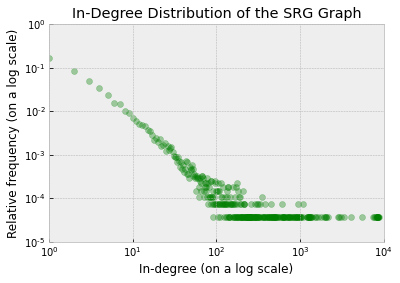

In [7]:
def make_srg(num_nodes, num_neighbors):
    """
    Creates a directed graph whereby there is an edge
    from each new node to num_neighbors of existing nodes.
    The probability of an existing node j being chosen in
    this process is (indeg(j) + 1) / (total_indeg + number
    of existing nodes).

    Returns a dictionary whose keys are nodes and values
    are edges whose tails are at key nodes.
    """

    digraph = {}

    # adding nodes 0 to num_neighbors - 1
    initial_nodes = range(num_neighbors)
    for node in initial_nodes:
        neighbors = set(initial_nodes)
        neighbors.remove(node)
        digraph[node] = neighbors

    nodes_to_choose = [node for node in digraph
                       for _ in range(num_neighbors)]

    # adding nodes num_neighbors to num_nodes - 1
    for node in range(num_neighbors, num_nodes):
        neighbors = set(random.choices(nodes_to_choose, k = num_neighbors))
        digraph[node] = neighbors
        nodes_to_choose.extend(neighbors)
        nodes_to_choose.append(node)

    return digraph

srg_graph = make_srg(NUM_NODES, NUM_NEIGHBORS)
in_degree_srg = in_degree_distribution(srg_graph)
plot_in_degree(in_degree_srg, (1, 10**4), (10**(-5), 1),
               "SRG Graph", "green")

## Conclusion
The in-degree distribution of the SRG graph and that of the citation graph have many similarities. Relative frequencies in both distributions decline with the in-degree; both are dense along the right-hand tail, and the relative frequencies of a specific in-degree in the two distributions are close to each other. However, the in-degree distribution of the citation graph has a parabolic shape between 1 and 100, while the shape of the SRG graph is more or less linear over the same range.

The behavior of the second random graph can be explained by a so-called “the rich get richer" phenomenon. Nodes 0 to 12 (those included into the complete digraph) have a much higher chance of receiving an edge than subsequent nodes. In addition, as a node’s in-degree rises, the probability of new nodes being connected to that node also increases.

The "rich get richer" phenomenon can also help explain the shape of the in-degree distribution of the citation graph. As a person writes a high energy physics theory paper, he or she is likely to cite a certain number of prior studies, the number of citations more or less the same among papers. While doing so, the physicist is likely to cite several key papers that already have a big number of citations. Also, papers published earlier naturally have a higher number of citations than newer studies.